In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten


In [2]:
count = 0
dirs = os.listdir(r'D:\Semester 5\Kuliah\ML\UAS\DATASET PISANG')

for dir in dirs:
    files = list(os.listdir(r'D:\Semester 5\Kuliah\ML\UAS\DATASET PISANG/'+dir))
    print(dir + ' Folder has ' + str(len(files)) + ' Images')
    count = count + len(files)
print('Images Folder has ' + str(count) + ' Images')

busuk Folder has 101 Images
masak Folder has 101 Images
mentah Folder has 101 Images
Images Folder has 303 Images


In [3]:
base_dir = r'D:\Semester 5\Kuliah\ML\UAS\DATASET PISANG' 
img_size = 180 
batch = 32 
validation_split = 0.1 

In [4]:
dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir, 
    seed=123, 
    image_size=(img_size, img_size), 
    batch_size=batch, 
)

Found 330 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names 
print("Class Names:", class_names)

Class Names: ['busuk', 'masak', 'mentah']


In [6]:
total_count = len(dataset)
val_count = int(total_count * validation_split)
train_count = total_count - val_count

print("Total Images:", total_count)
print("Train Images:", train_count)
print("Validation Images:", val_count)

Total Images: 11
Train Images: 10
Validation Images: 1


In [7]:
train_ds = dataset.take(train_count)
val_ds = dataset.skip(train_count)

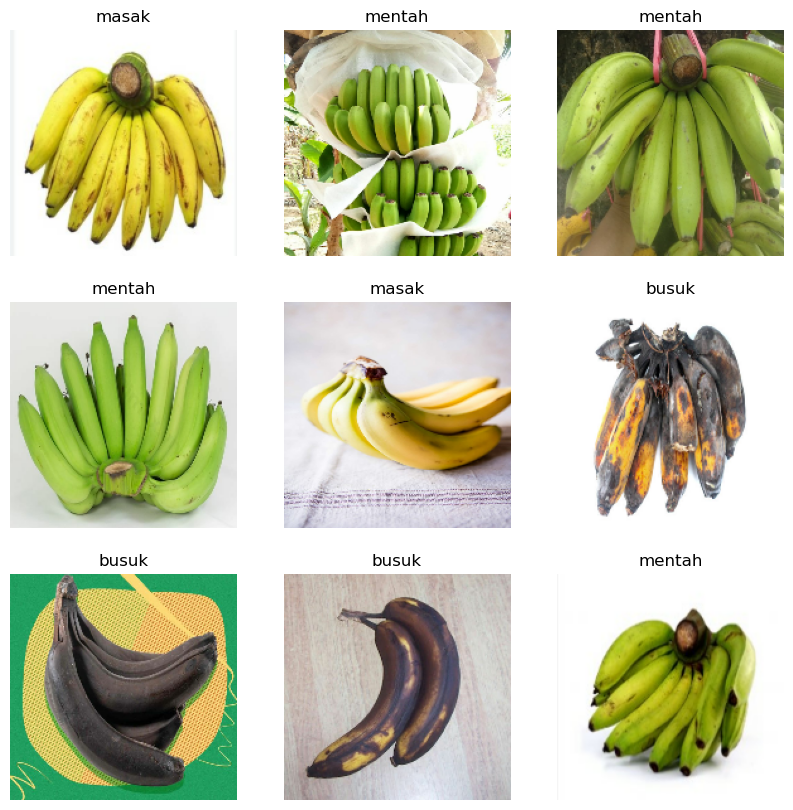

In [8]:
import matplotlib.pyplot as plt

i = 0
plt.figure(figsize=(10,10)) 

for images, labels in train_ds.take(1):
    for i in range(9): 
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [9]:
import numpy as np

for images, labels in train_ds.take(1):
    images_array = np.array(images)
    print(images_array.shape) 

(32, 180, 180, 3)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [12]:
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [13]:
data_augmentation = Sequential([
    layers.RandomFlip("diagonal", input_shape = (img_size,img_size,3)), 
    layers.RandomRotation(0.1), 
    layers.RandomZoom(0.1)
])

d:\Semester 5\Anaconda\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


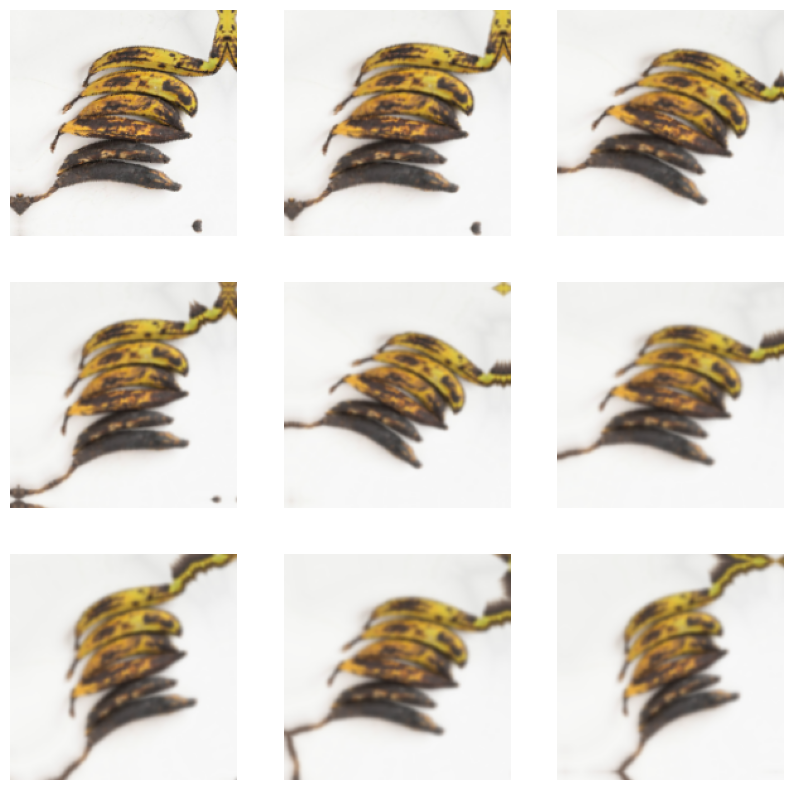

In [14]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [38]:
from keras.models import Model
from keras import optimizers
from keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

base_model = applications.VGG16(include_top=False, input_shape=(img_size, img_size, 3))

base_model.trainable = True
fine_tune_at = len(base_model.layers) // 2
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])



In [39]:
from tensorflow.keras.optimizers import Adam 

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,739 (56.38 MB)

 Trainable params: 13,635,331 (52.01 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=3,
                               mode='max')

history= model.fit(train_ds,
                   epochs=30, 
                   validation_data=val_ds,
                   callbacks=[early_stopping])

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.3907 - loss: 2.3951 - val_accuracy: 0.4000 - val_loss: 2.6912
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.3855 - loss: 1.3131 - val_accuracy: 0.2000 - val_loss: 1.1449
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.4041 - loss: 1.1198 - val_accuracy: 0.4000 - val_loss: 1.0619
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.4907 - loss: 0.8947 - val_accuracy: 0.5000 - val_loss: 0.8911
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.5808 - loss: 0.7482 - val_accuracy: 0.8000 - val_loss: 0.8756
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.6865 - loss: 0.5587 - val_accuracy: 0.4000 - val_loss: 0.9255
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.7509 - loss: 0.5563 - val_accuracy: 0.6000 - val_loss: 0.8192
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.8313 - loss: 0.4236 - val_accuracy: 0.8000 - val_loss:

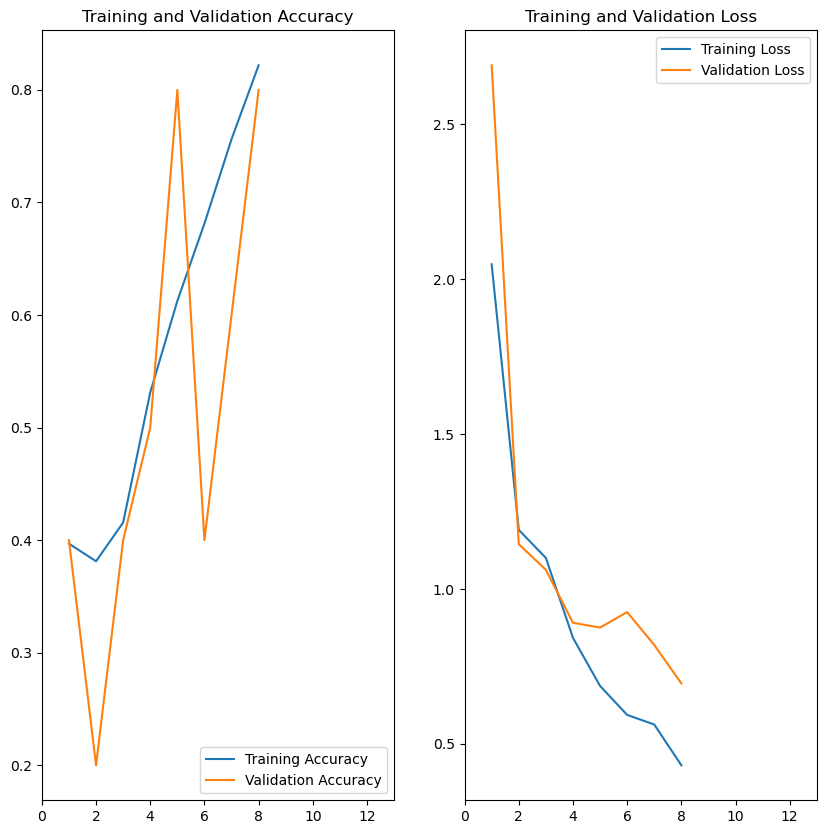

In [ ]:
ephocs_range = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.plot(ephocs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(ephocs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlim(0, 13)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(ephocs_range, history.history['loss'], label='Training Loss')
plt.plot(ephocs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlim(0, 13)
plt.title('Training and Validation Loss')
plt.show()

In [42]:
model.save('model_vgg16.h5')

In [45]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image

model = load_model(r'D:\Semester 5\Kuliah\ML\UAS\model_vgg16.h5')
class_names = ['busuk', 'masak', 'mentah']

def classify_images(image_path, save_path='predicted_image.jpg'):
    try:
        input_image = tf.keras.utils.load_img(image_path, target_size=(180, 180))
        input_image_array = tf.keras.utils.img_to_array(input_image)
        input_image_exp_dim = tf.expand_dims(input_image_array, 0)  


        predictions = model.predict(input_image_exp_dim)
        result = tf.nn.softmax(predictions[0])
        class_idx = np.argmax(result)
        confidence = np.max(result) * 100

        print(f"Prediksi: {class_names[class_idx]}")
        print(f"Confidence: {confidence:.2f}%")

        input_image = Image.open(image_path)
        input_image.save(save_path)

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"Terjadi kesalahan: {e}"

result = classify_images(r'DATASET PISANG/masak/matang03.jpg', save_path='matang.jpg')
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
Prediksi: masak
Confidence: 52.65%
Prediksi: masak dengan confidence 52.65%. Gambar asli disimpan di matang.jpg.


Found 20 files belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


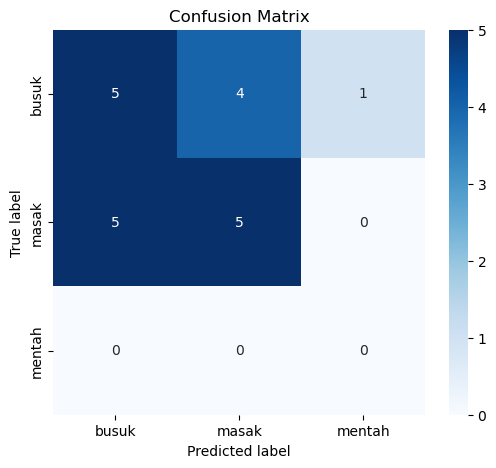

Confusion Matrix:
 [[5 4 1]
 [5 5 0]
 [0 0 0]]
Akurasi: 0.5
Presisi: [0.5        0.55555556 0.        ]
Recall: [0.5 0.5 nan]
F1 Score: [0.5        0.52631579        nan]


In [46]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt

mobileNet_model = load_model(r'D:\Semester 5\Kuliah\ML\UAS\model_vgg16.h5')

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    r'test_data', 
    labels='inferred', 
    label_mode='categorical', 
    batch_size=32,
    image_size=(180, 180)
)

y_pred = mobileNet_model.predict(test_data)
y_pred_class = tf.argmax(y_pred, axis=1)

true_labels = []
for _, labels in test_data:
    true_labels.extend(tf.argmax(labels, axis=1).numpy())
true_labels = tf.convert_to_tensor(true_labels)

conf_mat = tf.math.confusion_matrix(true_labels, y_pred_class)

accuracy = tf.reduce_sum(tf.linalg.diag_part(conf_mat)) / tf.reduce_sum(conf_mat)

precision = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=0)
recall = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=1)

f1_score = 2 * (precision * recall) / (precision + recall)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues',
            xticklabels=["busuk","masak", "mentah"], yticklabels=["busuk","masak", "mentah"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Menampilkan hasil
print("Confusion Matrix:\n", conf_mat.numpy())
print("Akurasi:", accuracy.numpy())
print("Presisi:", precision.numpy())
print("Recall:", recall.numpy())
print("F1 Score:", f1_score.numpy())
